In [28]:
import os
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# import cv2
import glob
import torchvision
from torch import nn
from tqdm import tqdm
from datetime import datetime

In [3]:
torch.__version__

'1.10.2'

## kaggle datasets

- weather-dataset
    - https://www.kaggle.com/datasets/jehanbhathena/weather-dataset?sort=votes
- 11 分类的图像分类问题
    - total 6862 张 images
- 类别（label）通过文件夹的名称体现

In [ ]:
# os.environ['KAGGLE_USERNAME'] = "..." # username from the json file
# os.environ['KAGGLE_KEY'] = "..." 
# !kaggle datasets download -d jehanbhathena/weather-dataset

In [4]:
data_dir = './weather-dataset/dataset/' 

In [5]:
os.listdir(data_dir)

['rime',
 'dew',
 'rain',
 'frost',
 '.DS_Store',
 'snow',
 'glaze',
 'hail',
 'fogsmog',
 'rainbow',
 'lightning',
 'sandstorm']

In [6]:
class_names = [f for f in os.listdir(data_dir) if not f.startswith('.')]
num_class = len(class_names)
print(num_class)
image_files = glob.glob(data_dir + '*/*.jpg', recursive=True)
len(image_files)

11


6862

In [7]:
image_files

['./weather-dataset/dataset/rime/5278.jpg',
 './weather-dataset/dataset/rime/4945.jpg',
 './weather-dataset/dataset/rime/5208.jpg',
 './weather-dataset/dataset/rime/5788.jpg',
 './weather-dataset/dataset/rime/5679.jpg',
 './weather-dataset/dataset/rime/4971.jpg',
 './weather-dataset/dataset/rime/4957.jpg',
 './weather-dataset/dataset/rime/6016.jpg',
 './weather-dataset/dataset/rime/5354.jpg',
 './weather-dataset/dataset/rime/5540.jpg',
 './weather-dataset/dataset/rime/5397.jpg',
 './weather-dataset/dataset/rime/5907.jpg',
 './weather-dataset/dataset/rime/5747.jpg',
 './weather-dataset/dataset/rime/5383.jpg',
 './weather-dataset/dataset/rime/5372.jpg',
 './weather-dataset/dataset/rime/5818.jpg',
 './weather-dataset/dataset/rime/5467.jpg',
 './weather-dataset/dataset/rime/6062.jpg',
 './weather-dataset/dataset/rime/5204.jpg',
 './weather-dataset/dataset/rime/5989.jpg',
 './weather-dataset/dataset/rime/5836.jpg',
 './weather-dataset/dataset/rime/6060.jpg',
 './weather-dataset/dataset/rime

In [8]:
idx_to_class = {i:j for i, j in enumerate(class_names)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [9]:
print(idx_to_class)
print(class_to_idx)

{0: 'rime', 1: 'dew', 2: 'rain', 3: 'frost', 4: 'snow', 5: 'glaze', 6: 'hail', 7: 'fogsmog', 8: 'rainbow', 9: 'lightning', 10: 'sandstorm'}
{'rime': 0, 'dew': 1, 'rain': 2, 'frost': 3, 'snow': 4, 'glaze': 5, 'hail': 6, 'fogsmog': 7, 'rainbow': 8, 'lightning': 9, 'sandstorm': 10}


## train valid test split

In [10]:
train_idx, test_idx, val_idx  = random_split(image_files, 
                                            [0.7, 0.2, 0.1], 
                                            generator=torch.Generator().manual_seed(42))

ValueError: Sum of input lengths does not equal the length of the input dataset!

In [11]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [12]:
train_idx, test_idx, val_idx  = random_split(image_files, 
                                            [0.7, 0.2, 0.1], 
                                            generator=torch.Generator().manual_seed(42))

In [13]:
print(len(train_idx))
print(len(test_idx))
print(len(val_idx))
print(sum([len(train_idx), len(test_idx), len(val_idx)]))

4804
1372
686
6862


In [14]:
train_idx.indices

[6330,
 5055,
 2218,
 1100,
 4522,
 1107,
 6090,
 4116,
 6794,
 6127,
 2828,
 2600,
 3922,
 1759,
 1701,
 5618,
 5811,
 1977,
 3497,
 1307,
 4287,
 5041,
 95,
 1237,
 4081,
 5897,
 5643,
 2481,
 4301,
 6470,
 466,
 2302,
 1737,
 2839,
 5043,
 3584,
 5843,
 1188,
 942,
 698,
 6072,
 5304,
 5079,
 3514,
 1121,
 5034,
 4509,
 5286,
 5603,
 6792,
 4084,
 5121,
 2312,
 4160,
 2820,
 4280,
 5395,
 5661,
 2952,
 6040,
 2086,
 5464,
 1602,
 6605,
 3532,
 172,
 313,
 4307,
 1543,
 4752,
 3807,
 4364,
 2266,
 5726,
 222,
 5766,
 6613,
 2349,
 4412,
 4233,
 3424,
 1831,
 4758,
 5792,
 5046,
 6585,
 4803,
 2365,
 819,
 3469,
 5253,
 2469,
 1147,
 4935,
 5123,
 847,
 3153,
 6371,
 5931,
 645,
 4004,
 4428,
 5439,
 4491,
 3375,
 1736,
 2371,
 4674,
 2351,
 2644,
 6493,
 2301,
 253,
 2856,
 1332,
 5151,
 5512,
 6236,
 613,
 3626,
 3449,
 1889,
 1719,
 251,
 4958,
 1299,
 6071,
 4134,
 6547,
 6455,
 1325,
 4458,
 2518,
 4337,
 1140,
 3384,
 1482,
 2135,
 5748,
 4811,
 3661,
 6038,
 3897,
 4267,
 2939,

In [15]:
train_list = [image_files[i] for i in train_idx.indices]
test_list = [image_files[i] for i in test_idx.indices]
val_list = [image_files[i] for i in val_idx.indices]

### 简单可视化

In [16]:
train_list[0]

'./weather-dataset/dataset/sandstorm/3460.jpg'

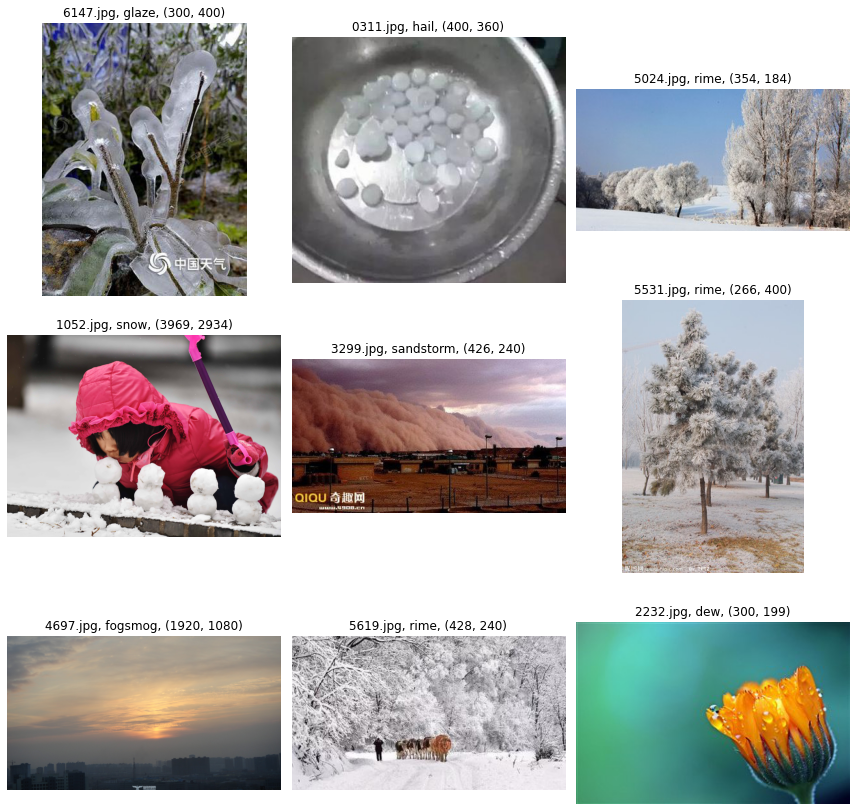

In [17]:
plt.subplots(3, 3, figsize=(12,12))
for i, k in enumerate(np.random.randint(len(train_list), size=9)):
    im = Image.open(train_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    img_name = train_list[k].split('/')[-1]
    img_label = train_list[k].split('/')[-2]
    plt.title(f"{img_name}, {img_label}, {im.size}")
#     plt.title(train_list[k].split('\\')[-2])
#     print(im.size)
    plt.imshow(arr, vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## custom Dataset/Dataloader

- Dataset 与 Dataloader
    - enumerate(train_dataloader)
    - DataLoader.\_\_next__
        - dataset.\_\_getitem__
            - transform
        - dataset.\_\_len__

In [19]:
class WeatherDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        
        # opencv 
#         image = cv2.imread(image_filepath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # pillow
        image = Image.open(image_filepath).convert('RGB')
        
        label = image_filepath.split('/')[-2]
#         label = image_filepath.split('\\')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [20]:
import timm
print(timm.data.IMAGENET_DEFAULT_MEAN)
print(timm.data.IMAGENET_DEFAULT_STD)

(0.485, 0.456, 0.406)
(0.229, 0.224, 0.225)


In [21]:
train_transforms = transforms.Compose([
#     transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
#     transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = WeatherDataset(train_list, train_transforms)
val_dataset = WeatherDataset(val_list, val_transforms)
test_dataset = WeatherDataset(test_list, val_transforms)

In [22]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

4804
1372
686


In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [24]:
images, labels = next(iter(train_dataloader))

In [25]:
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128])


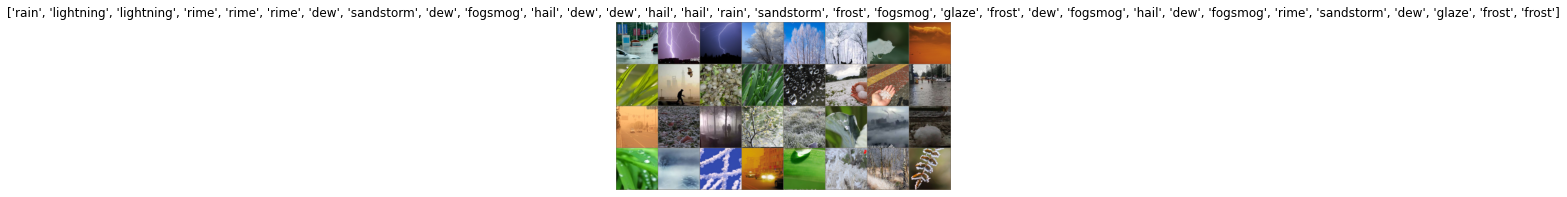

In [29]:
# x' = (x - mean)/std
# x = x' * std + mean
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.pause(1)  # pause a bit so that plots are updated


# Get a batch of training data
dataiter=iter(train_dataloader)
inputs, classes  = next(dataiter)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

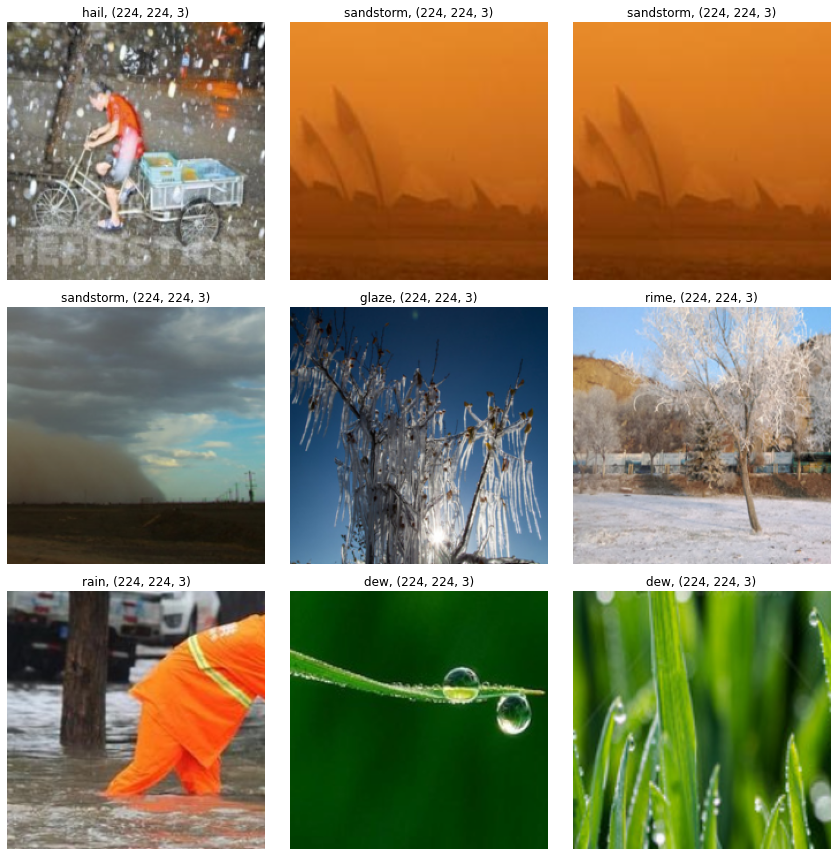

In [32]:
plt.subplots(3,3, figsize=(12,12))
for i, k in enumerate(np.random.randint(32, size=9)):
    im = images[k].numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = np.clip(im*std + mean, 0, 1)
#     arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.axis('off')
    img_label = idx_to_class[labels[k].item()]
    plt.title(f"{img_label}, {im.shape}")
#     plt.title(train_list[k].split('\\')[-2])
#     print(im.size)
    plt.imshow(im, )
plt.tight_layout()
plt.show()

## resnet

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
model = models.resnet34(pretrained=True)
input_lastLayer = model.fc.in_features
model.fc = nn.Linear(input_lastLayer, 11)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [ ]:
num_epochs = 200
min_valid_loss = np.inf
min_valid_acc = 0

n_total_step = len(train_dataloader)
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    train_corrects = 0
    for i, (imgs , labels) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        labels_hat = model(imgs)
        batch_corrects = (labels_hat.argmax(axis=1) == labels).sum().item()
        train_corrects += batch_corrects
        loss_value = criterion(labels_hat, labels)
        train_loss += loss_value.item()
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i+1) % 5 == 0:
            print(
                f'{datetime.now().strftime("%H:%M:%S")}, '
                f'epoch {epoch+1}/{num_epochs}, '
                f'step: {i+1}/{n_total_step}: loss = {loss_value:.5f}, '
                f'acc = {100*(batch_corrects/labels.size(0)):.2f}%')

    valid_loss = 0
    valid_corrects = 0
    model.eval()
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)

        loss = criterion(preds, labels)
        valid_loss += loss.item()

        batch_corrects = (preds.argmax(axis=1) == labels).sum().item()
        valid_corrects += batch_corrects

    valid_acc = valid_corrects/len(val_dataset)
    print(f'Epoch: {epoch}, '
          f'train_loss: {train_loss/len(train_dataloader)}, valid_loss: {valid_loss/len(val_dataloader)}, '
          f'train_acc: {train_corrects/len(train_dataset)}, valid_acc: {valid_corrects/len(val_dataset)}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased from {min_valid_loss} to {valid_loss}')
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), 'resnet_on_weather_loss.pth')

    if min_valid_acc < valid_acc:
        print(f'Validation accuracy increased from {min_valid_acc} to {valid_acc}')
        min_valid_acc = valid_acc
        torch.save(model.state_dict(), 'resnet_on_weather_acc.pth')

## load & test 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
model = models.resnet34(pretrained=True)
input_lastLayer = model.fc.in_features
model.fc = nn.Linear(input_lastLayer, 11)
model = model.to(device)
model.load_state_dict(torch.load('resnet_on_weather_loss.pth'))
model.load_state_dict(torch.load('resnet_on_weather_acc.pth'))

In [ ]:
total = 0
correct = 0

all_mis_preds = []
all_mis_labels = []
all_mis_images = []

for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    out = model(images)
    preds = torch.argmax(out, dim=1)
    total += images.size(0)
    correct += (preds == labels).sum().item()
    
    mis_preds_indice = torch.flatten((preds != labels).nonzero())
    mis_preds = preds[mis_preds_indice]
    mis_labels = labels[mis_preds_indice]
    mis_images = images[mis_preds_indice]
    
    all_mis_preds.extend(mis_preds)
    all_mis_labels.extend(mis_labels)
    
#     for i in range(mis_images.size(0)):
#         all_mis_images.append(unnormalize(mis_images[i]))
    
print(f'{correct}/{total}={correct/total}')